In [1]:
import tensorflow as tf
import numpy as np

In [12]:
import matplotlib.pyplot as plt

In [2]:
input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
    result = tf.square(input_var)

gradient = tape.gradient(result, input_var)

Remember that only trainable variables are being tracked by default. With a constant tensor, you'd have to manually mark it as being tracked, by calling tape.watch() on it:

In [3]:
input_const = tf.constant(3.)
with tf.GradientTape() as tape:
    tape.watch(input_const)
    result = tf.square(input_const)
    
gradient = tape.gradient(result, input_const)

We can also to solve second-order gradients

# End-to-End example: a linear classifier in pure tensorflow

### Building a linear classifier in tensorflow

In [5]:
# data
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, .5], [.5, 1]],
    size=num_samples_per_class
)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, .5], [.5, 1]],
    size=num_samples_per_class
)

In [8]:
# lets stack both vectors
negative_samples.shape, positive_samples.shape

((1000, 2), (1000, 2))

In [9]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)
inputs.shape

(2000, 2)

In [10]:
# generating the corresponding targets (0 and 1)
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

In [11]:
targets.shape

(2000, 1)

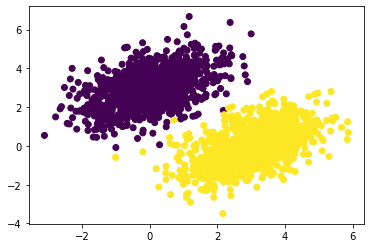

In [13]:
# plotting the data
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

A linear classifier is an affine transformation (prediction = w . input + b.

In [14]:
# Let's create our variables W and b
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim, )))

In [15]:
# forward pass function
def model(inputs):
    return tf.matmul(inputs, W) + b

Because our linear classifier operates on 2D inputs, W is really just two scalar coefficients, w1 and w2.
W = [[w1], [w2]]

In [17]:
# define the loss (mean squared error)
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

In [20]:
# training step function
learning_rate = 0.1

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(predictions, targets)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

will be using batch training (in all data), and not mini batch

In [21]:
# the batch training loop
for step in range(40):
    loss = training_step(inputs, targets)
    print("Loss at step {}: {:.4f}".format(step, loss))

Loss at step 0: 4.4159
Loss at step 1: 0.6333
Loss at step 2: 0.2025
Loss at step 3: 0.1447
Loss at step 4: 0.1295
Loss at step 5: 0.1198
Loss at step 6: 0.1114
Loss at step 7: 0.1038
Loss at step 8: 0.0969
Loss at step 9: 0.0905
Loss at step 10: 0.0848
Loss at step 11: 0.0795
Loss at step 12: 0.0747
Loss at step 13: 0.0703
Loss at step 14: 0.0663
Loss at step 15: 0.0626
Loss at step 16: 0.0593
Loss at step 17: 0.0562
Loss at step 18: 0.0534
Loss at step 19: 0.0509
Loss at step 20: 0.0486
Loss at step 21: 0.0465
Loss at step 22: 0.0445
Loss at step 23: 0.0428
Loss at step 24: 0.0412
Loss at step 25: 0.0397
Loss at step 26: 0.0384
Loss at step 27: 0.0371
Loss at step 28: 0.0360
Loss at step 29: 0.0350
Loss at step 30: 0.0341
Loss at step 31: 0.0332
Loss at step 32: 0.0325
Loss at step 33: 0.0317
Loss at step 34: 0.0311
Loss at step 35: 0.0305
Loss at step 36: 0.0300
Loss at step 37: 0.0295
Loss at step 38: 0.0290
Loss at step 39: 0.0286


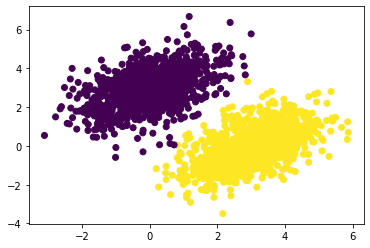

In [22]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

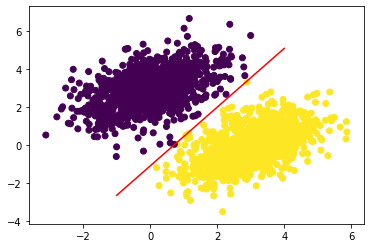

In [23]:
# plotting the line
x = np.linspace(-1, 4, 100)
y = - W[0] / W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

### The base LAYER class in Keras

Everything in Keras is either a Layer or something that closely interacts with a Layer. A Layer is an object that *encapsualtes some state* (**weights**) and *some computation* (a **forward pass**).

The weights are typically defined in a build() or in the constructor init(), and computation is defined in the call() method.

In [25]:
from tensorflow import keras

In [32]:
class SimpleDense(keras.layers.Layer):
    
    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation
        
    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim, self.units),
                                 initializer="random_normal")
        self.b = self.add_weight(shape=(self.units,),
                                 initializer="zeros")
        
    def call(self, inputs):
        y = tf.matmul(inputs, self.W) + self.b
        if self.activation is not None:
            y = self.activation(y)
        return y
    
    def __call__(self, inputs):
        if not self.built:
            self.build(inputs.shape)
            self.built = True
        return self.call(inputs)

In [27]:
my_dense = SimpleDense(units=32, activation=tf.nn.relu)
input_tensor = tf.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)


(2, 32)


# Automatic shape inference: building layers on the fly

We need layers that are compatible with each other to be able to execute the operations.

In [28]:
from tensorflow.keras import layers

In [29]:
# it can only be connected to a downstream layer that expects 32-dimensional vectors as its input
layer = layers.Dense(32, activation="relu")

In [30]:
from tensorflow.keras import models

In [31]:
model = models.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(32)
])

Remember that the weights are put on the build() method. And build() is called automatically the first time the layer is called (via its call()).

# From layers to models

- architecture

# The 'compile' step: configuring the learning proces

You need to set three more things after to choose the architecture: 
- loss function: will be minimized during training
- optimizer: the way you will update the weights based on loss feedback
- metrics: the metric will measure the sucess of your model, unlike loss function, metrics doesn't have to be differentiable.

In [33]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(
    optimizer="rmsprop",
    loss="mean_squared_error",
    metrics=["accuracy"]
)

# Understanding the fit method

After compile() comes fit(). The fit() method implements the training loop itself:
- the data (inputs and targets) to train
- the numer of epochs to train for
- the batch size to use

In [34]:
history = model.fit(
    inputs,
    targets,
    epochs=5,
    batch_size=128
)

Train on 2000 samples
Epoch 1/5
2000/2000 [==============================] - 0s 98us/sample - loss: 6.0930 - accuracy: 0.9950
Epoch 2/5
2000/2000 [==============================] - 0s 12us/sample - loss: 5.8076 - accuracy: 0.9955
Epoch 3/5
2000/2000 [==============================] - 0s 12us/sample - loss: 5.5669 - accuracy: 0.9955
Epoch 4/5
2000/2000 [==============================] - 0s 11us/sample - loss: 5.3353 - accuracy: 0.9955
Epoch 5/5
2000/2000 [==============================] - 0s 13us/sample - loss: 5.1098 - accuracy: 0.9955


In [38]:
# the call to fit returns a History object
# keep the losses and metrics for all epochs
history.history

{'loss': [6.092990997314453,
  5.807634525299072,
  5.5669477233886715,
  5.335283714294434,
  5.109806850433349],
 'accuracy': [0.995, 0.9955, 0.9955, 0.9955, 0.9955]}

In [39]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.BinaryAccuracy()]
)

# randomizing our data
indices_permutation = np.random.permutation(len(inputs))
shuffled_inputs = inputs[indices_permutation]
shuffled_targets = targets[indices_permutation]

# choosing how much data goes to validation
num_validation_samples = int(0.3 * len(inputs))
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]
model.fit(
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=16,
    validation_data=(val_inputs, val_targets)
)


Train on 1400 samples, validate on 600 samples
Epoch 1/5
1400/1400 [==============================] - 0s 238us/sample - loss: 0.0883 - binary_accuracy: 0.9450 - val_loss: 0.0836 - val_binary_accuracy: 0.9233
Epoch 2/5
1400/1400 [==============================] - 0s 108us/sample - loss: 0.0688 - binary_accuracy: 0.9543 - val_loss: 0.1545 - val_binary_accuracy: 0.8833
Epoch 3/5
1400/1400 [==============================] - 0s 98us/sample - loss: 0.0693 - binary_accuracy: 0.9636 - val_loss: 0.2093 - val_binary_accuracy: 0.6917
Epoch 4/5
1400/1400 [==============================] - 0s 105us/sample - loss: 0.0693 - binary_accuracy: 0.9571 - val_loss: 0.0552 - val_binary_accuracy: 0.9783
Epoch 5/5
1400/1400 [==============================] - 0s 105us/sample - loss: 0.0716 - binary_accuracy: 0.9564 - val_loss: 0.0642 - val_binary_accuracy: 0.9750


In [40]:
loss_and_metrics = model.evaluate(val_inputs, val_targets, batch_size=128)

600/600 [==============================] - 0s 33us/sample - loss: 0.0642 - binary_accuracy: 0.9750


In [41]:
loss_and_metrics

[0.06423188289006551, 0.975]

# Inference: using a model after training

Just use the .predict() method on the model

In [42]:
predictions = model.predict(val_inputs, batch_size=128)

In [44]:
predictions.shape

(600, 1)

In [45]:
val_inputs.shape

(600, 2)